In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from discretization import make_cube, load_nparray, is_positive
from settings import progress, extract_id, extracted_protein_suffix,training_examples_folder, \
extracted_ligand_suffix, extracted_data_test_folder, resolution_cube, nb_neg_ex_per_pos

from models import first_model

/home/jsquared/.local/share/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def get_cubes(nb_examples=128):
    """
    Return the first nb_examples cubes with their ys.
    :param nb_examples: 
    :return: list of cubes and list of their ys
    """
    examples_files = sorted(os.listdir(training_examples_folder))[0:nb_examples]

    cubes = []
    ys = []
    for index, ex_file in enumerate(examples_files):
        file_name = os.path.join(training_examples_folder, ex_file)
        example = load_nparray(file_name)

        cube = make_cube(example, resolution_cube)
        y = 1 * is_positive(ex_file)

        cubes.append(cube)
        ys.append(y)

    # Conversion to np.ndarrays with the first axes used for examples
    cubes = np.array(cubes)
    ys = np.array(ys)
    assert(ys.shape[0] == nb_examples)
    assert(cubes.shape[0] == nb_examples)

    return cubes, ys

In [5]:
def examples_iterator(data_folder) -> (np.ndarray, str, str):
    """
    Construct all the examples in the given folder

    :param data_folder:
    :return: a example (cube) at the time with the system used to construct the cube
    """
    # Getting all the systems
    list_systems_ids = set(list(map(extract_id, os.listdir(data_folder))))

    # For each system, we create the associated positive example and we generate some negative examples
    for system_id in progress(sorted(list_systems_ids)):
        protein = load_nparray(os.path.join(data_folder, system_id + extracted_protein_suffix))
        ligand = load_nparray(os.path.join(data_folder, system_id + extracted_ligand_suffix))

        # Yielding first positive example
        positive_example = np.concatenate((protein, ligand), axis=0)
        cube_pos_example = make_cube(positive_example, resolution_cube)
        yield cube_pos_example, system_id, system_id

        # Yielding all the others negatives examples with the same protein
        others_system = sorted(list(list_systems_ids.difference(set(system_id))))
        for other_system in others_system:
            bad_ligand = load_nparray(os.path.join(data_folder, other_system + extracted_ligand_suffix))

            # Saving negative example
            negative_example = np.concatenate((protein, bad_ligand), axis=0)
            cube_neg_example = make_cube(negative_example, resolution_cube)
            yield cube_neg_example, system_id, other_system

In [6]:
# Choosing the model
model = first_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_2 (Conv3D)            (None, 28, 28, 28, 32)    3488      
_________________________________________________________________
flatten_2 (Flatten)          (None, 702464)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 90)                63221850  
_________________________________________________________________
dense_6 (Dense)              (None, 60)                5460      
_________________________________________________________________
dense_7 (Dense)              (None, 30)                1830      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 31        
Total params: 63,232,659
Trainable params: 63,232,659
Non-trainable params: 0
________________________________________________________________

In [7]:
# We are taking systems of the first 200 proteins (pos and neg example)
nb_examples = 200 * (1 + nb_neg_ex_per_pos)
cubes, ys = get_cubes(nb_examples)
print("Done loading dataset")

Done loading dataset


In [8]:
# Training the network
history = model.fit(cubes, ys)

Epoch 1/1
2200/2200 [==============================] - 513s 233ms/step - loss: 0.0928 - acc: 0.9041 - mean_pred: 0.0074


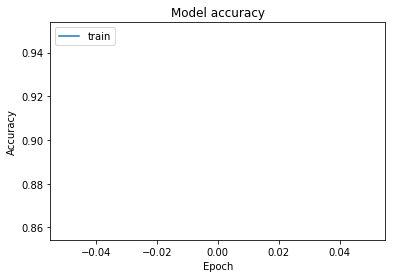

In [9]:
# Summarize history for Accuracy
plt.plot(history.history['acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Testing
from settings import progress
ys = []
y_preds = []
for cube, protein_system, ligand_system in progress(examples_iterator(extracted_data_test_folder)):
    y = 1 * (protein_system == ligand_system)
    cube = np.array([cube])
    y_pred = model.predict(cube)
    ys.append(y)
    y_preds.append(y_pred)

 [Elapsed Time: 0:05:35] |░⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅⋅| (ETA:      N/A) 

In [ ]:
# Do some analysis here
# Confusion matrix, metrics